In [10]:
import networkx as nx
import os.path

In [11]:
from google.colab import drive
drive.mount('/content/drive')

output_dir = "/content/drive/MyDrive/Maestria/AyED"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Para graficar
POINTS_N = 150   # Numero de points
MIN_VAL = 2     # minimo valor coordenadas
MAX_VAL = 7    # maximo valor coordenadas
# ancho de línea para visualización K-D tree
LINE_WIDTH = [4., 3.5, 3., 2.5, 2., 1.5, 1., .5, .3]
DELTA = 1

In [13]:
def distance_squared(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    dx = x1 - x2
    dy = y1 - y2
    return dx * dx + dy * dy

In [14]:
def plot_tree(R,tree, min_x, max_x, min_y, max_y, prev_node, branch, depth=0):
    cur_node = tree.value
    left_branch = tree.left
    right_branch = tree.right
    if depth > len(LINE_WIDTH)-1:
        ln_width = LINE_WIDTH[len(LINE_WIDTH)-1]
    else:
        ln_width = LINE_WIDTH[depth]
    k = len(cur_node)
    axis = depth % k
    if axis == 0:
        if branch is not None and prev_node is not None:
            if branch:
                max_y = prev_node[1]
            else:
                min_y = prev_node[1]
        plt.plot([cur_node[0],cur_node[0]], [min_y,max_y],
                 linestyle='-', color='#6BB3F4', linewidth=ln_width)
    elif axis == 1:
        if branch is not None and prev_node is not None:
            if branch:
                max_x = prev_node[0]
            else:
                min_x = prev_node[0]
        plt.plot([min_x,max_x], [cur_node[1],cur_node[1]], linestyle='-', color='#F08080', linewidth=ln_width)
    plt.plot(cur_node[0], cur_node[1], 'ko')
    if left_branch is not None:
        plot_tree(R,left_branch, min_x, max_x, min_y, max_y, cur_node, True, depth+1)
    if right_branch is not None:
        plot_tree(R,right_branch, min_x, max_x, min_y, max_y, cur_node, False, depth+1)

In [15]:

def plot_result(root, point, point_nn, output_dir: str) -> None:
    plt.figure('K-D Tree', figsize=(10., 10.))
    plt.axis([MIN_VAL - DELTA, MAX_VAL + DELTA,
              MIN_VAL - DELTA, MAX_VAL + DELTA])

    plt.grid(visible=True, which='major', color='0.75', linestyle='--')
    plt.xticks(range(MIN_VAL - DELTA, MAX_VAL + DELTA))
    plt.yticks(range(MIN_VAL - DELTA, MAX_VAL + DELTA))

    R=[]
    plot_tree(R,root, MIN_VAL-DELTA, MAX_VAL + DELTA, MIN_VAL - DELTA, MAX_VAL + DELTA, None, None)

    #plt.plot(point[0], point[1], marker='o', color='#ff007f')
    #circle = plt.Circle((point[0], point[1]), 0.3, facecolor='#ff007f',
    #                    edgecolor='#ff007f', alpha=0.5)
    #plt.gca().add_patch(circle)

    #circle = plt.Circle((point[0], point[1]), distance_squared(point, point_nn),
    #                    facecolor='#ffd83d', edgecolor='#ffd83d', alpha=0.5)
    #plt.gca().add_patch(circle)

    #plt.plot(point_nn[0], point_nn[1], 'go')
    #circle = plt.Circle((point_nn[0], point_nn[1]), 0.3, facecolor='#33cc00',
    #                    edgecolor='#33cc00', alpha=0.5)
    #plt.gca().add_patch(circle)
    plt.title('KD Tree')
    plt.savefig(os.path.join(output_dir, 'KDTree.png'))
    plt.show()
    plt.close()

In [16]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):
    #if not nx.is_tree(G):
    #    raise TypeError('No se puede usar porque no es un arbol')
        #return None
    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))
        else:
            root = random.choice(list(G.nodes))
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        #children = children.sort()
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children)!=0:
            dx = width/len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap,
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [17]:
def generate_data(node):
    texto = ""
    if node == None:
        return " "
    if node.left != None:
        texto+=str(node.value)[1:-1]+'\t'+str(node.left.value)[1:-1]+'\t'+str(node.axis)+'\n'
        texto+=generate_data(node.left)
    if node.right != None:
        texto+=str(node.value)[1:-1]+'\t'+str(node.right.value)[1:-1]+'\t'+str(node.axis)+'\n'
        texto+=generate_data(node.right)
    return texto

def create_archivo(archivo,texto):
    archivo = open(archivo, "w")
    archivo.write(texto)
    archivo.close()

def graph_create(root,archivo):
    knode_i=str(root.value)[1:-1]
    plt.figure(figsize=(8,8))
    G = nx.Graph()
    G_0=nx.Graph()
    G_1=nx.Graph()
    data = pd.read_csv(archivo, sep="\t", header=None)
    size = int(len(data[[1]]))
    for row in range(size):
        if data[2][row] == 0:
            G_0.add_node(data[0][row])
            G_1.add_node(data[1][row])
        if data[2][row] == 1:
            G_1.add_node(data[0][row])
            G_0.add_node(data[1][row])
        G.add_edge(data[0][row],data[1][row])
    pos = hierarchy_pos(G,knode_i)
    options = {"edgecolors": "tab:gray", "node_size": 1200, "alpha": 1}
    nx.draw(G, pos=pos, with_labels=False)
    # nodes
    nx.draw_networkx_nodes(G, pos, nodelist=G_0, node_color="skyblue", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=G_1, node_color="lightcoral", **options)
    # edges
    nx.draw_networkx_edges(G, pos, edge_color="tab:gray", arrows = True)
    # labels
    nx.draw_networkx_labels(G, pos, font_size=7)
    plt.suptitle('KD Tree', fontsize=13, fontweight ="bold")
    plt.savefig('KDTreeGrafo.png')
    plt.show()



IRIS


predicted: 1  real: 1
predicted: 1  real: 1
predicted: 2  real: 2
predicted: 0  real: 0
predicted: 1  real: 1
precision: 100.0%


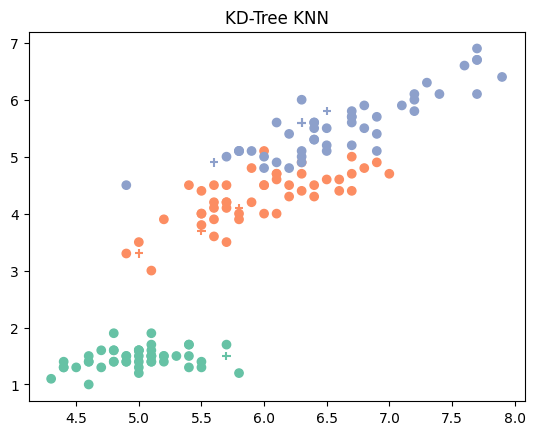

In [23]:
import numpy as np
import pandas as pd
import time
import math
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from random import randint
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
#plt.rcdefaults()


def quicksort(array, start, end, axis):
    """
    sort array of k-dimensional points along specified axis using quicksort
    """
    if start < end:
        pivot = partition(array, start, end, axis)
        quicksort(array, start, pivot - 1, axis)
        quicksort(array, pivot + 1, end, axis)


def partition(array, start, end, axis):
    """
    partitions along specified axis for dimension-wise quicksort
    """
    pivot = array[start][axis]
    left = start + 1
    right = end
    done = False
    while not done:
        while left <= right and array[left][axis] <= pivot:
            left = left + 1
        while array[right][axis] >= pivot and right >= left:
            right = right - 1
        if right < left:
            done = True
        else:
            temp = array[left]
            array[left] = array[right]
            array[right] = temp
    temp = array[start]
    array[start] = array[right]
    array[right] = temp
    return right

# ------------------------------ GRAFICOS -------------------------------

def cv_plotter(kList, accuracyTest, accuracyTrain):
    fig, ax = plt.subplots()
    barWidth = 0.35
    opacity = 0.8

    rects1 = plt.bar(
        kList, accuracyTrain, barWidth, alpha=opacity, color="b", label="Train accuracy"
    )

    rects2 = plt.bar(
        kList + np.repeat(barWidth, len(kList)),
        accuracyTest,
        barWidth,
        alpha=opacity,
        color="g",
        label="Test accuracy",
    )

    plt.xlabel("k")
    plt.ylabel("Scores")
    plt.title("Resultados")
    plt.xticks(kList)  # + np.repeat(barWidth,len(kList)), barWidth, tuple(kList))
    plt.legend()
    plt.tight_layout()
    plt.savefig("Accuracy.png")
    plt.show()


def plot_points(knownPoints, knownLabels, unknownPoints, predictedLabels):
    xKnown, yKnown = zip(*knownPoints)
    xUnknown, yUnknown = zip(*unknownPoints)
    # df_known = pd.DataFrame({'x' : xKnown, 'y' : yKnown, 'color' : knownLabels})
    # df_unknown = pd.DataFrame({'x' : xUnknown, 'y' : yUnknown, 'color' : predictedLabel})
    colorLabels = list(set(knownLabels))
    rgbValues = sns.color_palette("Set2", 100)
    colorMap = dict(zip(colorLabels, rgbValues))
    colorsKnown = []
    colorsUnknown = []
    #pprint(knownLabels)
    #pprint(colorLabels)
    #pprint(colorMap)

    for knownLabel in knownLabels:
        colorsKnown.append(colorMap[knownLabel])
    for predictedLabel in predictedLabels:
        colorsUnknown.append(colorMap[predictedLabel])

    plt.scatter(xKnown, yKnown, c=colorsKnown)
    plt.scatter(xUnknown, yUnknown, c=colorsUnknown, marker="+")
    plt.title('KD-Tree KNN')
    plt.savefig("Clasificación.png")
    plt.show()



def print_neighbours(candidates):
    for node in candidates:
        print("node: " + str(node[1].value) + " , distance: " + str(node[0]))


def gen_cloud(num, dims, min_, max_):
    return [[randint(min_, max_) for i in range(dims)] for j in range(num)]


def to_dict(points, target):
    """
    converts array of points with array of labels, to dict with label as value and point as key
    """
    if len(points) != len(target):
        raise ValueError("The points and label arrays shoud have the same length.")

    pointsLabelDict = {}
    for i, point in enumerate(points):
        pointsLabelDict[tuple(point)] = target[i]

    return pointsLabelDict


def print_preds(predictions, labelDict):
    c = 0
    precision = 0
    for key in labelDict:
        if c == 5:
            break
        print("predicted: " + str(predictions[c]) + "  real: " + str(labelDict[key]))
        if predictions[c] == labelDict[key]:
            precision += 1
        c += 1

    print("precision: " + str(100 * precision / c) + "%")

# -------------------- lOAD DATASET -----------------------------------

def load_dataset_iris(twoClasses=True):
    """
    if twoClasses is True we select only classes 0 and 1
    """
    data = load_iris()
    if twoClasses:
        x = data["data"]
        y = data["target"]
        data["data"] = np.array([x[i] for i in range(len(x)) if y[i] in (2, 1)])
        data["target"] = np.array([i for i in y if i in (2, 1)])

    randIndex = np.random.choice(len(data["data"]), 10)

    pointsTrain = np.delete(data["data"], randIndex, 0).tolist()
    targetTrain = np.delete(data["target"], randIndex, 0).tolist()
    pointsTest = data["data"][randIndex].tolist()
    targetTest = data["target"][randIndex].tolist()

    # selecting columns of iris for plotting
    toPlotTrain = np.delete(data["data"], randIndex, 0)[:, [0, 2]].tolist()
    toPlotTest = data["data"][randIndex][:, [0, 2]].tolist()

    #print(pointsTrain, targetTrain)
    #print(data["data"][randIndex])

    return pointsTrain, targetTrain, pointsTest, targetTest, toPlotTrain, toPlotTest


def load_dataset_breast_cancer(twoClasses=True):
    """
    if twoClasses is True we select only classes 0 and 1
    """
    data = load_breast_cancer()
    if twoClasses:
        x = data["data"]
        y = data["target"]
        data["data"] = np.array([x[i] for i in range(len(x)) if y[i] in (2, 1)])
        data["target"] = np.array([i for i in y if i in (2, 1)])

    randIndex = np.random.choice(len(data["data"]), 10)

    pointsTrain = np.delete(data["data"], randIndex, 0).tolist()
    targetTrain = np.delete(data["target"], randIndex, 0).tolist()
    pointsTest = data["data"][randIndex].tolist()
    targetTest = data["target"][randIndex].tolist()

    # selecting columns of iris for plotting
    toPlotTrain = np.delete(data["data"], randIndex, 0)[:, [0, 2]].tolist()
    toPlotTest = data["data"][randIndex][:, [0, 2]].tolist()

    #print(pointsTrain, targetTrain)
    #print(data["data"][randIndex])

    return pointsTrain, targetTrain, pointsTest, targetTest, toPlotTrain, toPlotTest

# --------------------------------------------------------------------------------------------

def cv_splitter(originalSetLen, k):
    splits = []
    if k > originalSetLen:
        foldSize = 1
    else:
        foldSize = originalSetLen // k
    # print("originalSetLen : ",originalSetLen)
    indexes = list(range(originalSetLen))
    while len(indexes) >= foldSize:
        split = np.random.choice(indexes, size=foldSize, replace=False).tolist()
        splits.append(split)
        indexes = list(set(indexes) - set(split))
    if len(indexes) > 0:
        splits[-1].extend(indexes)
    return splits


def train_test_splitter(originalSetLen, testPercentage):
    testIndexes = []
    allIndexes = list(range(originalSetLen))
    nTest = int(np.round(originalSetLen * testPercentage))
    testIndexes = np.random.choice(allIndexes, size=nTest, replace=False).tolist()
    return testIndexes


def test_to_train_indexes(originalSetLen, testIndexes):
    allIndexes = list(range(originalSetLen))
    # print ("allIndexes : ",allIndexes)
    # print ("testIndexes : ",testIndexes)
    trainIndexes = list(set(allIndexes) - set(testIndexes))
    return trainIndexes


def cv(knownPoints, testPercentage, kFold, rangeKNn, labelDic, reps, naive=False):
    accResultsCv = []
    originalSetLen = len(knownPoints)
    testIndexes = train_test_splitter(originalSetLen, testPercentage)
    trainIndexes = test_to_train_indexes(originalSetLen, testIndexes)
    testSet = [knownPoints[i] for i in testIndexes]
    testSetLabels = []
    for testPoint in testSet:
        testSetLabels.append(labelDic[tuple(testPoint)])
    trainSet = [knownPoints[i] for i in trainIndexes]
    trainSetLen = len(trainSet)
    cvResultTest = []
    cvResultTrain = []
    for kNn in rangeKNn:
        for rep in range(reps):
            d = 0
            print("cv rep number : ", rep + 1)
            testCvIndexesList = cv_splitter(trainSetLen, kFold)
            for testCvIndexes in testCvIndexesList:
                print("cv fold number : ", d + 1)
                trainCvIndexes = test_to_train_indexes(trainSetLen, testCvIndexes)
                testCvSet = [trainSet[i] for i in testCvIndexes]
                trainCvSet = [trainSet[i] for i in trainCvIndexes]
                testCvLabels = []
                for testCvPoint in testCvSet:
                    testCvLabels.append(labelDic[tuple(testCvPoint)])
                    if not naive:
                        predictionsCv = batch_knn(trainCvSet, testCvSet, labelDic, kNn)
                    else:
                        predictionsCv = naive_knn(trainCvSet, testCvSet, labelDic, kNn)
                accCv = accuracy(testCvLabels, predictionsCv)
                accResultsCv.append(accCv)
                d += 1
        cvResultTrain.append(np.mean(accResultsCv))
        predictions_test = batch_knn(trainSet, testSet, labelDic, kNn)
        cvResultTest.append(accuracy(testSetLabels, predictions_test))
        print(
            "ending cv at mean inner test accuracy : ",
            cvResultTrain[-1],
            " test acc : ",
            cvResultTest[-1],
        )
    return cvResultTest, cvResultTrain


def accuracy(yTrue, yPred):
    boolRes = []
    for truth, pred in zip(yTrue, yPred):
        boolRes.append(truth == pred)
    intRes = list(map(int, boolRes))
    accuracy = np.sum(intRes) / len(yTrue)
    return accuracy


#_------------------------ Kd-tree -------------------------
class Node:

    def __init__(
        self, value=None, parent=None, left=None, right=None, axis=None, visited=False
    ):
        self.value = value  # coordinates of point
        self.parent = parent
        self.left = left
        self.right = right
        self.axis = axis
        self.visited = visited

    def has_children(self):
        return False if self.right is None and self.left is None else True

    def set_visited(self):
        self.visited = True

    def __str__(self, depth=0):
        """
        modified snippet of Steve Krenzel
        """
        dim = len(self.value)
        ret = ""

        # Print right branch
        if self.right is not None:
            ret += self.right.__str__(depth + 1)

        # Print own value
        ret += "\n" + ("    " * depth * dim) + str(self.value)

        # Print left branch
        if self.left is not None:
            ret += self.left.__str__(depth + 1)

        return ret

    def reset(self):
        """
        sets all visited values to false
        """
        self.visited = False

        if self.right is not None:
            self.right.reset()
        if self.left is not None:
            self.left.reset()


def create_tree(pointList, dimensions, depth=0, parent=None):
    """
    creates Kd-tree, pointsList is the list of points. dimensions is the dimension of
    the euclidean space in which these points are present (or number od fimensions
    along which you want to split the data). depth is the starting tree-depth
    """

    if not pointList:
        return

    if not dimensions:
        dimensions = len(pointList[0])  # selects all dimensions to split along

    axis = depth % dimensions  # switch dimensions at each split

    # pointList.sort(key=lambda point: point[axis])
    # shellSort(pointList,axis)
    quicksort(pointList, 0, len(pointList) - 1, axis)

    med = len(pointList) // 2
    root = Node(value=pointList[med], parent=parent, axis=axis, visited=False)
    root.left = create_tree(
        pointList=pointList[:med], dimensions=dimensions, depth=depth + 1, parent=root
    )
    root.right = create_tree(
        pointList=pointList[med + 1 :],
        dimensions=dimensions,
        depth=depth + 1,
        parent=root,
    )
    #print(root.value)
    #print(root)


    return root


def calculate_dist(point, node):
    """
    returns euclidean distance between 2 points
    """

    if len(point) != len(node.value):
        return
    vect = np.array(point) - np.array(node.value)
    summed = np.dot(vect, vect)
    return math.sqrt(summed)

def nearest_neighbours(
    point, node, candidateList, distMin=math.inf, k=1, verbose=False
):

    if node is None or node.visited:
        return

    dist = calculate_dist(point, node)

    if dist < distMin:
        candidateList.append([dist, node])
        candidateList.sort(key=lambda point: point[0])
        distMin = candidateList[-1][0]

    if len(candidateList) > k:
        if verbose:
            print("removing candidates")
        candidateList.pop()  # removes last one (biggest distance)

    if point[node.axis] < node.value[node.axis]:
        nearest_neighbours(point, node.left, candidateList, distMin, k)
        if node.value[node.axis] - point[node.axis] <= distMin:
            nearest_neighbours(point, node.right, candidateList, distMin, k)
        else:
            if verbose:
                print("pruned right branch of " + str(node.value))
    else:
        nearest_neighbours(point, node.right, candidateList, distMin, k)
        if point[node.axis] - node.value[node.axis] <= distMin:
            nearest_neighbours(point, node.left, candidateList, distMin, k)
        else:
            if verbose:
                print("pruned left branch of " + str(node.value))

    node.visited = True

tree = 0

def batch_knn(knownPoints, unknownPoints, labelDic, k):
    tree = create_tree(pointList=knownPoints, dimensions=len(knownPoints[0]))
    predictions = []
    for point in unknownPoints:
        # print(point)
        candidates = []
        nearest_neighbours(point=point, node=tree, candidateList=candidates, k=k)
        candidateslabelsDic = {}
        for node in candidates:
            candidate = tuple(node[1].value)
            if labelDic[candidate] in candidateslabelsDic:
                candidateslabelsDic[labelDic[candidate]] += 1
            else:
                candidateslabelsDic[labelDic[candidate]] = 1
        predictedLabel = max(
            candidateslabelsDic, key=candidateslabelsDic.get
        )  # assuming if equality of count each key has a random chance to be the first of this result
        predictions.append(predictedLabel)
        tree.reset()
    return predictions





# ------------------------ MAIN -----------------------------------------------------

def main():

    # we test the performance of our method using data from the iris dataset and plots the results
    print("\n\n" + 100 * "=" + "\nIRIS\n\n")
    (
        pointsTrain,
        targetTrain,
        pointsTest,
        targetTest,
        toPlotTrain,
        toPlotTest,
    ) = load_dataset_iris(twoClasses=False)

    pointsDictTrain = to_dict(pointsTrain, targetTrain)
    pointsDictTest = to_dict(pointsTest, targetTest)
    dicIris = {**pointsDictTrain, **pointsDictTest}
    predictions = batch_knn(pointsTrain, pointsTest, pointsDictTrain, 1)
    print_preds(predictions, pointsDictTest)
    plot_points(toPlotTrain, targetTrain, toPlotTest, predictions)

    # Metrica
    kList = [50,100,150]
    #cvResultTest, cvResultTrain = cv(pointsTrain, 0.1, 2, kList, dicIris, 1)
    #print(cvResultTest, cvResultTrain)
    #cv_plotter(kList, cvResultTest, cvResultTrain)

    # Call Graficos

    # -------------
    #lista_data = generate_data(tree)
    #create_archivo("dataset.csv", lista_data)
    #graph_create(tree,'dataset.csv')
    #pivot = (6.0,2.2,5.0,1.5)
    #found = kdtree_closest_point(kdTree, pivot)
    #found = (6.2,3.4,5.4,2.3)
    #plot_result(tree, pivot, found, output_dir)

    # ---------------

if __name__ == "__main__":
    main()

